In [31]:
def lr_find(learn, start_lr=1e-7, end=10, num_it=100, beta=0.9) :
    sm = SmoothenValue(beta)
    iteration = 0
    best_loss = 0
    losses = []
    lrs = []
    learn.model.cuda()
    for batch in learn.data.train_dl :
        #print(iteration)
        new_lr = annealing_exp(start_lr, end, iteration/num_it)
        for p in learn.opt.param_groups :
            p['lr'] = new_lr
        
        xb = batch.text.t().cuda()
        yb = batch.target.t().cuda()
        pred = learn.model(xb)[0]
        loss = learn.loss_func(pred, yb)
        
        sm.add_value(loss.item())

        losses.append(sm.smooth)
        lrs.append(new_lr)
        
        
        if iteration==0 or loss < best_loss: best_loss = loss
        if iteration > num_it or (loss > 4*best_loss or torch.isnan(loss)):
            break
        iteration+=1

    return losses, lrs


In [32]:
losses, lrs = lr_find(learner_pretrained)

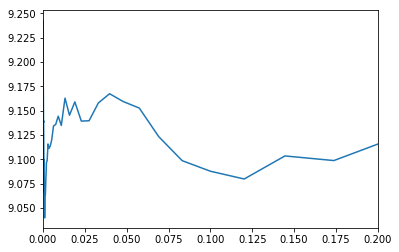

In [36]:
fig, ax = plt.subplots(1, 1)
ax.set_xlim(0, 0.2)
ax.plot(lrs, losses)

In [29]:
lrs

[1e-07,
 1.202264434617413e-07,
 1.4454397707459274e-07,
 1.7378008287493754e-07,
 2.0892961308540395e-07,
 2.51188643150958e-07,
 3.019951720402016e-07,
 3.6307805477010137e-07,
 4.36515832240166e-07,
 5.248074602497725e-07,
 6.309573444801933e-07,
 7.585775750291837e-07,
 9.120108393559096e-07,
 1.096478196143185e-06,
 1.3182567385564074e-06,
 1.5848931924611132e-06,
 1.9054607179632473e-06,
 2.2908676527677735e-06,
 2.754228703338166e-06,
 3.311311214825911e-06,
 3.981071705534973e-06,
 4.7863009232263826e-06,
 5.754399373371569e-06,
 6.918309709189365e-06,
 8.317637711026708e-06,
 9.999999999999999e-06,
 1.202264434617413e-05,
 1.4454397707459279e-05,
 1.737800828749376e-05,
 2.0892961308540385e-05,
 2.5118864315095795e-05,
 3.019951720402016e-05,
 3.630780547701014e-05,
 4.365158322401661e-05,
 5.248074602497728e-05,
 6.309573444801929e-05,
 7.585775750291836e-05,
 9.120108393559096e-05,
 0.00010964781961431851,
 0.00013182567385564074,
 0.0001584893192461114,
 0.00019054607179632

In [15]:
lm = get_language_model(AWD_LSTM, len(vocab))

In [16]:
lm

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60002, bias=True)
    (output_dp): RNNDropout()
  )
)

In [17]:
model_path = untar_data('https://s3.amazonaws.com/fast-ai-modelzoo/wt103-1', data=False)

In [18]:
fnames = [list(model_path.glob(f'*.{ext}'))[0] for ext in ['pth', 'pkl']]

In [19]:
old_itos = pickle.load(open(fnames[1], 'rb'))
old_stoi = {v:k for k,v in enumerate(old_itos)}

In [20]:
wgts = torch.load(fnames[0], map_location=lambda storage, loc: storage)

In [21]:
wgts.keys()

odict_keys(['0.encoder.weight', '0.encoder_dp.emb.weight', '0.rnns.0.weight_hh_l0_raw', '0.rnns.0.module.weight_ih_l0', '0.rnns.0.module.weight_hh_l0', '0.rnns.0.module.bias_ih_l0', '0.rnns.0.module.bias_hh_l0', '0.rnns.1.weight_hh_l0_raw', '0.rnns.1.module.weight_ih_l0', '0.rnns.1.module.weight_hh_l0', '0.rnns.1.module.bias_ih_l0', '0.rnns.1.module.bias_hh_l0', '0.rnns.2.weight_hh_l0_raw', '0.rnns.2.module.weight_ih_l0', '0.rnns.2.module.weight_hh_l0', '0.rnns.2.module.bias_ih_l0', '0.rnns.2.module.bias_hh_l0', '1.decoder.weight', '1.decoder.bias'])

In [22]:
wgts = convert_weights(wgts, old_stoi, vocab.itos)

In [23]:
list(lm.named_parameters())[0]

('0.encoder.weight', Parameter containing:
 tensor([[-0.0825, -0.0992, -0.0490,  ...,  0.0177, -0.0033,  0.0554],
         [-0.0285, -0.0871, -0.0559,  ..., -0.0675, -0.0639, -0.0579],
         [ 0.0404,  0.0203,  0.0496,  ..., -0.0570,  0.0078,  0.0426],
         ...,
         [-0.0593,  0.0399,  0.0047,  ...,  0.0030,  0.0478,  0.0297],
         [ 0.0198,  0.0324, -0.0988,  ...,  0.0287, -0.0798,  0.0871],
         [ 0.0849, -0.0758, -0.0118,  ...,  0.0830, -0.0535, -0.0667]],
        requires_grad=True))

In [24]:
list(lm.named_parameters())[0][1].mean()

tensor(5.6770e-06, grad_fn=<MeanBackward0>)

In [25]:
lm.load_state_dict(wgts)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [26]:
list(lm.named_parameters())[0]

('0.encoder.weight', Parameter containing:
 tensor([[ 0.2356, -0.0249,  0.1637,  ..., -0.0054, -0.0643, -0.1600],
         [ 0.2356, -0.0249,  0.1637,  ..., -0.0054, -0.0643, -0.1600],
         [ 0.2356, -0.0249,  0.1637,  ..., -0.0054, -0.0643, -0.1600],
         ...,
         [ 0.1646, -0.0526,  0.3163,  ...,  0.1312, -0.0608, -0.1023],
         [ 0.2014,  0.0848,  0.1379,  ..., -0.0200, -0.1992, -0.1391],
         [ 0.1610, -0.2437,  0.1706,  ..., -0.1507, -0.0739, -0.2293]],
        requires_grad=True))

In [27]:
((list(lm.named_parameters())[0][1] == list(lm.named_parameters())[0][1][0, :])).type(FloatTensor).mean()

tensor(0.5103)

In [38]:
def train_epochs(epochs, model, iterator_train, loss_function, optimizer, lr=0.2, iterator_valid = None, show_info=True, **kwargs) :
    
    losses = []
    opt = optimizer(model.parameters(), lr=lr)
    
    model.cuda()
    for i in range(epochs) :
        train_loss = 0
        counter = 0
        accuracy = 0
        model.train()
        batches = tqdm(iterator_train, leave=False,
                     total=len(iterator_train), desc=f'Epoch {i}')
        for batch in batches :
            x = batch.text
            y = batch.target
            x = x.cuda()
            y = y.cuda()
            pred = model(x.transpose(0,1))
            loss = loss_function(pred, y.transpose(0,1))
            train_loss += loss
            counter += 1
            accuracy += (torch.argmax(pred, dim=2) == y.transpose(0,1)).type(torch.FloatTensor).mean() 
            loss.backward()
            opt.step()
            opt.zero_grad()
        train_loss = train_loss/float(counter)
        accuracy = accuracy/float(counter)
        
        if iterator_valid is not None :
            counter_v = 0

            model.eval()
            valid_loss = 0
            accuracy_valid = 0
            for batch in iterator_valid :
                x = batch.text
                y = batch.target
                x = x.cuda()
                y = y.cuda()
                pred = model(x.transpose(0,1))
                loss = loss_function(pred, y.transpose(0,1))
                valid_loss += loss
                accuracy_valid += (torch.argmax(pred, dim=2) == y.transpose(0,1)).type(torch.FloatTensor).mean() 
                counter_v+= 1
            valid_loss = train_loss/float(counter_v)
            accuracy_valid = accuracy_valid/float(counter_v)
            losses.append(valid_loss)
            if show_info:
                print("Epoch {:.0f} training loss : {:.3f}, train accuracy : {:.3f}, validation loss : {:.3f}, val accuracy : {:.3f}".format(i, train_loss, accuracy, valid_loss, accuracy_valid))
        
        else :
            if show_info :
                print("Epoch {:.0f} training loss : {:.3f}, train accuracy : {:.3f}").format(i, train_loss, accuracy)
    return losses

### Callbacks

In order to modifiy the training loop without having to write another one eah time, we will use callbacks. A callback is is an object that will be called at different stages of the taining loop. This allows a to modify the training in a multitude of ways (hyper paramenter scheduling/recording, regularization techniques etc) and as mentionned, creating another training loop comes down to giving another set of callbacks. For more information refer to  [Fast.ai — An infinitely customizable training loop with Sylvain Gugger](https://www.youtube.com/watch?v=roc-dOSeehM)

![callbcaks](images/callbacks.png)
(picture from [Fast.ai — An infinitely customizable training loop with Sylvain Gugger
](https://www.youtube.com/watch?v=roc-dOSeehM))

We will now go through a simplified version of fastai's callback implementation

In [203]:
class mCallback():
    def begin_fit(self, learn):
        self.learn = learn
        self.in_train=True
        return True
    def after_fit(self): return True
    def begin_epoch(self, epoch):
        self.epoch=epoch
        return True
    def begin_validate(self): 
        self.in_train= False
        return True
    def after_epoch(self): return True
    def begin_batch(self, xb, yb):
        self.xb,self.yb = xb,yb
        return True
    def after_pred(self, pred) :
        self.pred = pred
        return 
    def after_loss(self, loss):
        self.loss = loss
        return True
    def after_backward(self): return True
    def after_step(self): return True

In [205]:
class mCallbackHandler():
    """
    Handles a list of callbacks
    """
    def __init__(self,cbs=None):
        self.cbs = cbs if cbs else []

    def begin_fit(self, learn):
        self.learn,self.in_train = learn,True
        learn.stop = False
        res = True
        for cb in self.cbs: res = res and cb.begin_fit(learn)
        return res

    def after_fit(self):
        res = not self.in_train
        for cb in self.cbs: res = res and cb.after_fit()
        return res
    
    def begin_epoch(self, epoch):
        self.learn.model.train()
        self.in_train=True
        res = True
        for cb in self.cbs: res = res and cb.begin_epoch(epoch)
        return res

    def begin_validate(self):
        self.learn.model.eval()
        self.in_train=False
        res = True
        for cb in self.cbs: res = res and cb.begin_validate()
        return res

    def after_epoch(self):
        res = True
        for cb in self.cbs: res = res and cb.after_epoch()
        return res
    
    def begin_batch(self, xb, yb):
        res = True
        for cb in self.cbs: res = res and cb.begin_batch(xb, yb)
        return res
    
    def after_pred(self, pred):
        self.pred = pred
        for cb in self.cbs: cb.after_pred(pred)
        return
    
    def after_loss(self, loss):
        res = True
        for cb in self.cbs: res = res and cb.after_loss(loss)
        return res and self.in_train

    def after_backward(self):
        res = True
        for cb in self.cbs: res = res and cb.after_backward()
        return res

    def after_step(self):
        res = True
        for cb in self.cbs: res = res and cb.after_step()
        return res
    
    def do_stop(self):
        try:     return self.learn.stop
        finally: self.learn.stop = False

This is the result of our fit function using callbacks and a bit of refactoring

In [201]:
def mone_batch(xb, yb, cb):
    #print('starting one batch')
    if not cb.begin_batch(xb,yb): return
    pred = cb.learn.model(xb)
    cb.after_ped(pred)
    loss = cb.learn.loss_func(pred, yb)
    if not cb.after_loss(loss): return
    loss.backward()
    if cb.after_backward(): cb.learn.opt.step()
    if cb.after_step(): cb.learn.opt.zero_grad()


def mall_batches(dl, cb):
    #print('Starting all batches')
    for xb,yb in dl:
        mone_batch(xb, yb, cb)
        if cb.do_stop(): return

def mfit(epochs, learn, cb):
    if not cb.begin_fit(learn): return
    for epoch in range(epochs):
        #print('Satrting new epoch')
        if not cb.begin_epoch(epoch): continue
        mall_batches(learn.data.train_dl, cb)
        
        if cb.begin_validate():
            with torch.no_grad(): mall_batches(learn.data.valid_dl, cb)
        if cb.do_stop() or not cb.after_epoch(): break
    cb.after_fit()

### Example 

As this might be a lot of this to digest, here is a simple example of linear regression.

In [118]:
import matplotlib

In [164]:
x = torch.FloatTensor(range(100)).view(-1, 1)
y =  2*x  + torch.randn(100, 1) * 10

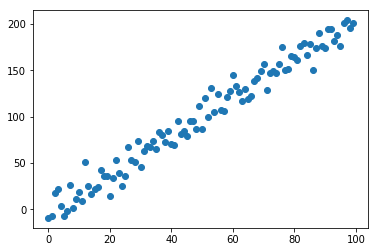

In [165]:
plt.scatter(x.view(-1), y.view(-1))
plt.show()

So we want to learn y from x. Let's create the train and valid dataloaders and the databunch

In [166]:
full_ds = TensorDataset(x, y)
full_dl = DataLoader(full_ds)

In [167]:
from torch.utils.data import TensorDataset, DataLoader

In [168]:
permutaion = np.random.permutation(100)
train_idx = permutaion[:80]
valid_idx = permutaion[80:]
train_ds = TensorDataset(x[train_idx], y[train_idx])
valid_ds = TensorDataset(x[valid_idx], y[valid_idx])

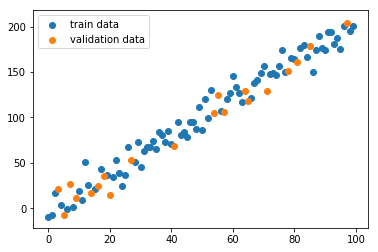

In [190]:
plt.scatter(train_idx, y[train_idx], label='train data')
plt.scatter(valid_idx, y[valid_idx], label='validation data')
plt.legend()
plt.show()

In [191]:
train_dl, valid_dl = DataLoader(train_ds, batch_size=10),  DataLoader(valid_ds, batch_size=10)

In [192]:
data = Databunch(train_dl, valid_dl)

Now we need create our learner


In [193]:
model = nn.Linear(1, 1)
opt = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)
loss_func = mse
learn = mLearner(model, opt, loss_func, data)

Now that we have all we need to train, let's create a callback that will print the training and validation loss after each epoch.

In [194]:
class LossPrinter(mCallback) :
    def begin_epoch(self, epoch) :
        self.epoch = epoch
        self.in_train = True
        self.training_loss = 0
        self.training_count = 0
        self.validation_loss = 0
        self.validation_count = 0
        return True
    
    def after_loss(self, loss) :
        self.loss = loss
        if self.in_train :
            #print("train")
            self.training_loss += loss
            self.training_count += 1
        else :
            #print("val")
            self.validation_loss += loss
            self.validation_count += 1
        return True
    def after_epoch(self) :
        tr_loss = self.training_loss/self.training_count
        val_loss = self.validation_loss/self.validation_count
        print(f"Epoch {self.epoch} : train loss : {tr_loss}, val loss : {val_loss}")
        return True

In [195]:
cb = mCallbackHandler(cbs=[LossPrinter()])

In [196]:
mfit(10, learn, cb)

Epoch 0 : train loss : 6893.0673828125, val loss : 1007.7388916015625
Epoch 1 : train loss : 3165.007080078125, val loss : 1616.822998046875
Epoch 2 : train loss : 1126.92333984375, val loss : 1126.4425048828125
Epoch 3 : train loss : 610.1114501953125, val loss : 297.632080078125
Epoch 4 : train loss : 358.3578796386719, val loss : 276.0628662109375
Epoch 5 : train loss : 205.29539489746094, val loss : 163.21835327148438
Epoch 6 : train loss : 142.3311767578125, val loss : 171.56991577148438
Epoch 7 : train loss : 131.19882202148438, val loss : 156.42144775390625
Epoch 8 : train loss : 122.08387756347656, val loss : 123.480224609375
Epoch 9 : train loss : 111.4623031616211, val loss : 145.77081298828125


As we can see, this callback prints the taining and validation loss after each epoch, we could use callback to modify the learning rate after each epoch, use gradiant clipping and infinitely other things. We will now use use a better implemementation of callbacks :

In [ ]:
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        self.xb,self.yb = xb,yb
        if self('begin_batch'): return
        self.pred = self.model(self.xb)
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred, self.yb)
        if self('after_loss') or not self.in_train: return
        self.loss.backward()
        if self('after_backward'): return
        self.opt.step()
        if self('after_step'): return
        self.opt.zero_grad()

    def all_batches(self, dl):
        self.iters = len(dl)
        for xb,yb in dl:
            if self.stop: break
            self.one_batch(xb, yb)
            self('after_batch')
        self.stop=False

    def fit(self, epochs, learn):
        self.epochs,self.learn,self.loss = epochs,learn,tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                if self('after_epoch'): break
            
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, cb_name, None)
            if f and f(): return True
        return False

### AWD LSTM training loop

With callbacks implemented, we are ready to implement the teaks used in the AWD LSTM trainig loop training 

In [207]:
??Callback

In [198]:
class GradientClipping(Callback):
    def __init__(self, clip=None): self.clip = clip
    def after_backward(self):
        if self.clip:  nn.utils.clip_grad_norm_(self.run.model.parameters(), self.clip)
        return True

In [206]:
class RNNTrainer(Callback):
    def __init__(self, α, β): self.α,self.β = α,β
    
    def after_pred(self):
        #Save the extra outputs for later and only returns the true output.
        self.raw_out,self.out = self.pred[1],self.pred[2]
        self.run.pred = self.pred[0]
        return True
    
    def after_loss(self):
        #AR and TAR
        if self.α != 0.:  self.loss += self.α * self.out[-1].float().pow(2).mean()
        if self.β != 0.:
            h = self.raw_out[-1]
            if len(h)>1: self.run.loss += self.β * (h[:,1:] - h[:,:-1]).float().pow(2).mean()
        return True
    
    def begin_epoch(self):
        #Shuffle the texts at the beginning of the epoch
        if hasattr(self.dl.dataset, "batchify"): self.dl.dataset.batchify()
        return True